# Least Square Fit

The purpose of this notebook is to illustrate the method of applying that matrix inverse to input data is an efficient way of fitting parameters.

In [1]:
import numpy as np
import scipy as sp
import time
import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt

#begin declaring primary functions (matrix squareroot and a check function)
def matrixsqrt(V, label="0", returntime=False):
    start = time.time()
    N = len(V[0])
    wt = np.empty([N,N]) #square root matrix (transposed)
    logdet = 0.
    #extracts eigenvalues and eigenvectors (bottleneck!)
    eigs, eigvecs = sp.linalg.eigh(V)
    for i in range(N):
        #sets each column in our transposed square root to the eigenvalue scaled by 1/sqrt(eig)
        wt[:,i] = (1./np.sqrt(eigs[i])) * eigvecs[:,i]
        logdet += np.log(2 * np.pi * eigs[i])
        #transposes the result
    w = np.ndarray.transpose(wt)
    end = time.time()
    dt = end-start
    if(label!="0"):
        print("Time elapsed for " + label + " is: " + str(dt) + "s")
    if(returntime==True):
        return w, logdet, dt
    else:
        return w, logdet

def ismsqrt(w,V):
    N = len(V[0])
    if(np.allclose(np.dot(V, np.dot(np.ndarray.transpose(w), w)),np.identity(N))):
        return True
    else:
        return False
    
#variance matrix generators
def makeV2(N, sigmarange=[100,300]):
    sigma2 = np.random.rand(N)*(sigmarange[1]-sigmarange[0]) + sigmarange[0]
    V2 = sigma2 * np.identity(N)
    return V2

def makeV3(N, sigmarange=[100,300], A=300, tau=30):
    K = np.empty([N,N])
    t = np.arange(N, dtype='int')
    for i in range(N):
        for j in range(N):
            K[i][j] = A * np.exp(-0.5 * (t[i]-t[j])**2 / (tau **2))
    V3 = makeV2(N, sigmarange=sigmarange) + K
    return V3

#importing preferred model
def expf(x, a, b):
    return np.exp((a*(x-b)))

def linef(x, a, b):
    return a*x + b

def linef2 (x, x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    b = y2 - (m*x2)
    return ((m*x) + b)

def piecewise(x, params): # params are: xl, xr, a1, b1, a3, b3
        xl = params[0]
        xr = params[1]
        a1 = params[2]
        b1 = params[3]
        a3 = params[4]
        b3 = params[5]
        result = np.empty(len(x))
        for i in range(len(x)):
                if(x[i]<=xl):
                    result[i] = expf(x[i], a1, b1)
                elif (x[i]>xl and x[i]<=xr):
                    result[i] = linef2(x[i], xl, expf(xl,a1,b1), xr, expf(xr, a3, b3))
                elif (x[i]>xr):
                    result[i] = expf(x[i], a3, b3)
        return result


Let's see if we need to use $w$ or $w^T$:

In [2]:
#opening data
data1 = "/Users/chris/Documents/QPP/SolarFlareGPs/data/121022782_ctime_lc.txt"
t1, I1 = np.loadtxt(data1, unpack=True)

#from prior fit, estimations of piecewise function
params = [1100, 1500, 1.3e-2, 100, -9e-3, 2900]

#check to use w over wT:
def checkw(params, I, t):
    V = makeV3(len(t))
    w, logdet = matrixsqrt(V)
    model = piecewise(t, params)
    resid = np.dot(w, (I - model))
    chisq = np.dot(resid, resid)
    resid2 = (I-model)
    Vinv = np.linalg.inv(V)
    chisq2 = np.dot(resid2, np.dot(Vinv,resid2))
    print chisq
    print chisq2
    print (chisq-chisq2)

#checkw(params, I1, t1)
#w is correct

V1 = makeV3(len(I1), A=300, tau=30)
V2 = makeV3(len(I1), A=600, tau=60)
V3 = makeV3(len(I1), A=150, tau=15)
w1 = matrixsqrt(V1)
w2 = matrixsqrt(V2)
w3 = matrixsqrt(V3)



[  1.10068815e+03   1.50517245e+03   1.16160610e-02  -1.28183058e+01
  -5.93196150e-03   3.60257996e+03]
[  1.13450595e+03   1.49021036e+03   6.17716337e-03  -9.38251465e+02
  -5.47366783e-03   3.77790506e+03]
[  1.07478227e+03   1.50423296e+03   1.92032139e-02   4.00509436e+02
  -6.01277190e-03   3.57506754e+03]


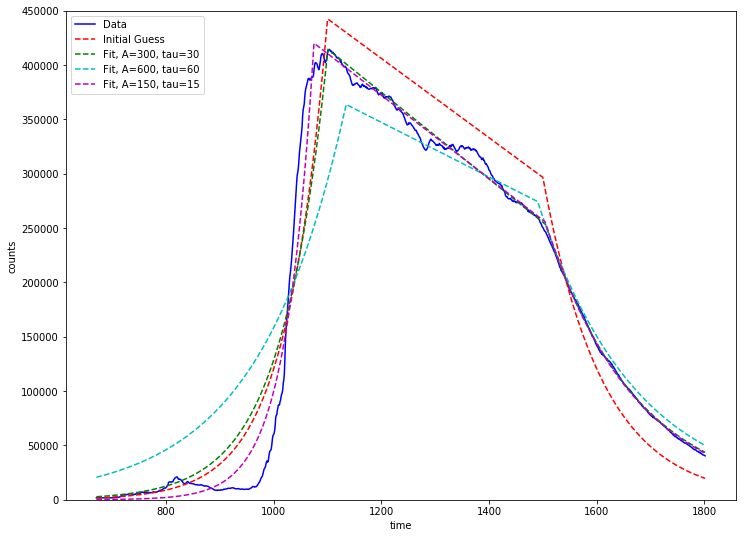

In [14]:
#define residual function, using
def residualPW(paramsPW, w, I, t):
    model = piecewise(t, paramsPW)
    return np.dot(w, (I - model))

def residualPW2(paramsPW, paramsV, I, t):
    model = piecewise(t, paramsPW)
    return (I - model)

opt1, flag = sp.optimize.leastsq(residualPW, params, args = (w1[0],I1,t1))
opt2, flag = sp.optimize.leastsq(residualPW, params, args = (w2[0],I1,t1))
opt3, flag = sp.optimize.leastsq(residualPW, params, args = (w3[0],I1,t1))
print opt1
print opt2
print opt3
Iinit = piecewise(t1, params)
Ifit1 = piecewise(t1, opt1)
Ifit2 = piecewise(t1, opt2)
Ifit3 = piecewise(t1, opt3)

plt.figure(figsize=(12,9))
plt.ylim(0,450000)
plt.xlabel("time")
plt.ylabel("counts")
plt.plot(t1, I1, 'b-', label='Data')
plt.plot(t1, Iinit,'r--', label='Initial Guess')
plt.plot(t1, Ifit1,'g--', label='Fit, A=300, tau=30')
plt.plot(t1, Ifit2,'c--', label='Fit, A=600, tau=60')
plt.plot(t1, Ifit3,'m--', label='Fit, A=150, tau=15')
plt.legend(loc='upper left')
plt.show()
